In [1]:
import numpy as np
import pandas as pd
import biosppy.signals.ecg as ecg
import biosppy.signals.tools as tools
import matplotlib.pyplot as plt

In [2]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer, KNNImputer


## Dataset import and export

In [3]:
def load_from_csv(extension="", mustDropId = True):
    X_train = pd.read_csv('data/X_train' + extension + '.csv')
    y_train = pd.read_csv('data/y_train' + extension + '.csv')
    X_test  = pd.read_csv('data/X_test' + extension + '.csv')
    
    if mustDropId:
        X_train = X_train.drop(columns=['id'])
        y_train = y_train.drop(columns=['id'])
        X_test  = X_test.drop(columns=['id'])
     
    return X_train, y_train, X_test

In [4]:
def export_to_csv(X_train, y_train, X_test, extension="_cleaned"):
    X_train.to_csv('data/X_train' + extension + '.csv', index=False)
    y_train.to_csv('data/y_train' + extension + '.csv', index=False)
    X_test.to_csv('data/X_test' + extension + '.csv', index=False)

## Create CSV for submission

In [5]:
def create_submission(sub_id, pred, basepath='submissions/task2-sub'):
    result = pred.copy().rename(columns={0: 'y'})
    result['id'] = range(0, len(result))
    result = result[['id', 'y']]
    result.to_csv(basepath + str(sub_id) + '.csv', index=False)

## Plot helper functions

In [6]:
def plot_raw_signal_sample(raw_signal):
    # Some matplotlib setting 
    plt.rcParams["figure.figsize"] = (30, 5)
    plt.rcParams['lines.linewidth'] = 5
    plt.rcParams['xtick.labelsize'] = 24
    plt.rcParams['ytick.labelsize'] = 32
    plt.rcParams['axes.labelsize'] = 48
    plt.rcParams['axes.titlesize'] = 48

    fig, axs = plt.subplots(1, 1)

    seconds = np.arange(0, 600) / 30 
    x_labels = [0, 5, 10, 15, 20]

    ax = axs
    
    measurements = raw_signal.dropna().to_numpy(dtype='float32')
    # Get a subsequence of a signal and downsample it for visualization purposes
    measurements = measurements[1000:7000:10] 
    # convert volts to millivolts
    measurements /= 1000
    ax.plot(seconds, measurements, color='k')
    ax.set_xticks(x_labels)

    fig.tight_layout()

    # Display x- and y-labels for the whole plot
    ax = fig.add_subplot(111, frameon=False)
    # hide tick and tick label of the big axes
    plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    ax.yaxis.set_label_coords(-0.05, 0.5)
    plt.xlabel('Time [s]')
    plt.ylabel('Amplitude [mV]')            
    plt.show()

In [7]:
def plot_beats(beats):
    pd.DataFrame(np.mean(beats, axis=0)).plot()
    pd.DataFrame(beats.transpose()).plot()

## Helper functions

In [8]:
"""Return the indices of all the members of a class

Parameters
----------
y_train : pd.df
    The labels
class_nbr: int (0<=class_nbr<=3)
    The class for which we want to retrieve the indexes
    
Return
------
np.array
     All the indexes of the given class
"""
def get_indices_class(y_train, class_nbr = 0):
    assert class_nbr>=0 and class_nbr<=3
    return np.argwhere(y_train['y'].to_numpy() == class_nbr).reshape(-1)

## Task 1: Data processing `TODO`

In [9]:
def series_to_heartbeats(time_series: pd.Series, sampling_rate=300.0) -> np.array:
    no_nans = time_series.dropna()
    rpeaks = ecg.engzee_segmenter(no_nans, sampling_rate)['rpeaks']
    beats, rpeaks = ecg.extract_heartbeats(no_nans, rpeaks, sampling_rate)
    beats = beats if len(beats.shape) == 2 else beats.reshape((1, -1))
    return beats, rpeaks

In [10]:
#WARNING: CAN RETURN NAN values
def find_hearthrate_info(rpeaks, sampling_rate=300.0):
    index, heart_rates = tools.get_heart_rate(beats=rpeaks, sampling_rate=sampling_rate, smooth=False)
    heart_rates_std = np.std(heart_rates) #Especially important to classify class 1 from the others
    heart_rates_median = np.median(heart_rates) #Probably not very useful
    return heart_rates_std, heart_rates_median

In [11]:
"""Easy but not very efficient way to have an idea of the noise in the signal (almost only to find class 3)

Parameters
----------
beats : np.array
    The beats of a single signal computed with the previous methods
quantile:
    The quantile
    
Return
------
float
    The given quantile of the standard deviation of the different beats. For the class 3 with a lot of noise, this should be quite high but for the other relatively low
"""
def compute_quantile_noise_in_beats(beats, quantile=0.35):
    return np.quantile(np.std(beats, axis=0), quantile)

In [12]:
def find_important_values(mean_beats, epsilon=3):
    
    R_index = np.argmax(mean_beats)
    R_amplitude = mean_beats[R_index]
    S_index = R_index+np.argmin(mean_beats[R_index:]) if R_index != len(mean_beats) else R_index #Especially useful or class 2 which should be low
    S_amplitude = mean_beats[S_index]
        
    counter=R_index-1
    index_min_before_R = np.argmin(mean_beats[:R_index]) if R_index != 0 else 0
    found=False
    while not found and counter >= index_min_before_R:
        if(mean_beats[counter+1]-mean_beats[counter]<epsilon):
            found=True
        counter-=1
    
    Q_index = counter
    Q_amplitude = mean_beats[Q_index]
    QRS_duration = S_index - Q_index #Not in real time, in this resample time, but shouldn't change anything
    
    return R_amplitude, S_amplitude, Q_amplitude, QRS_duration

## Task 2: Models defintion `TODO`

In [37]:
def best_svc(X_train, y_train):
    svc = SVC()
    gs_svc_params = {
        'kernel': ['rbf'],#['rbf', 'poly', 'sigmoid'],
        'C': np.logspace(0, 3, 6),
        'class_weight': ['balanced', None] #To have weights according to the number in each classes
    }
    gs_svc = GridSearchCV(svc, gs_svc_params, cv=5, verbose=3, error_score='raise')
    gs_svc.fit(X_train, y_train)
    
    print(f"""The best validation score obtained is {gs_svc.best_score_:.5f} with
    \tkernel: {gs_svc.best_params_['kernel']}
    \tC: {gs_svc.best_params_['C']}""")
    
    return gs_svc

## Task3: Rescale the data

In [15]:
def scale(X_feature_train, X_features_test):
    # Do the scaling, saving the scaler to use it for X_test too. No need imputation, just ignore Nan values
    scaler = StandardScaler().fit(X_feature_train)
    X_train_scaled = scaler.transform(X_feature_train)
    # Cast X_test to np.array to avoid warning of model trained without feature names but X having some.
    X_test_scaled = scaler.transform(X_features_test)
    return (X_train_scaled, X_test_scaled)

## Main Pipeline

In [16]:
X_train_raw, y_train_raw, X_test_raw = load_from_csv()

### Data exploration

In [17]:
print(f"X_train shape: {X_train_raw.shape}")
print(f"y_train shape: {y_train_raw.shape}")
print(f"X_test shape: {X_test_raw.shape}")

X_train shape: (5117, 17842)
y_train shape: (5117, 1)
X_test shape: (3411, 17842)


In [18]:
# For each signal, compute its beats and rpeaks
X_train_beats_rpeaks = X_train_raw.apply(lambda r: pd.Series(series_to_heartbeats(r)), axis=1).to_numpy()
X_test_beats_rpeaks = X_test_raw.apply(lambda r: pd.Series(series_to_heartbeats(r)), axis=1).to_numpy()

# Doesn't work, problem with serialization: the arrays are tranformed into strings
#X_train_beats_rpeaks, y_train_raw, X_test_beats_rpeaks = load_from_csv(extension = "_beats_rpeaks", mustDropId=False)
#X_train_beats_rpeaks = X_train_beats_rpeaks.to_numpy()
#X_test_beats_rpeaks = X_test_beats_rpeaks.to_numpy()

In [19]:
#Problem, the library doesn't seem to work perfectly for all signals
nbr_beats_train = np.array([len(beats) for beats, _ in X_train_beats_rpeaks])
indexes_too_low_beats_train = np.argwhere(nbr_beats_train < 2).reshape(-1)
nbr_rpeaks_train = np.array([len(rpeaks) for _, rpeaks in X_train_beats_rpeaks])
index_no_rpeaks_train = np.argwhere(nbr_rpeaks_train <= 0).reshape(-1)
print(f"In the training set, there are {len(indexes_too_low_beats_train)} signal which don't have enough beats to detect the hearthrate (minimum 2 needed) and from these, {len(index_no_rpeaks_train)} don't have any rpeaks detected (=> the {len(indexes_too_low_beats_train)-len(index_no_rpeaks_train)} remaining only have 1 rpeak).")

nbr_beats_test = np.array([len(beats) for beats, _ in X_test_beats_rpeaks])
indexes_too_low_beats_test = np.argwhere(nbr_beats_test < 2).reshape(-1)
nbr_rpeaks_test = np.array([len(rpeaks) for _, rpeaks in X_test_beats_rpeaks])
index_no_rpeaks_test = np.argwhere(nbr_rpeaks_test <= 0).reshape(-1)
print(f"\nIn the test set, there are {len(indexes_too_low_beats_test)} signal which don't have enough beats to detect the hearthrate (minimum 2 needed) and from these, {len(index_no_rpeaks_test)} don't have any rpeaks detected (=> the {len(indexes_too_low_beats_test)-len(index_no_rpeaks_test)} remaining only have 1 rpeak).")

In the training set, there are 36 signal which don't have enough beats to detect the hearthrate (minimum 2 needed) and from these, 19 don't have any rpeaks detected (=> the 17 remaining only have 1 rpeak).

In the test set, there are 26 signal which don't have enough beats to detect the hearthrate (minimum 2 needed) and from these, 17 don't have any rpeaks detected (=> the 9 remaining only have 1 rpeak).


In [20]:
indexes_too_low_beats_train

array([  65,  447,  579,  593,  955, 1082, 1135, 1171, 1247, 1383, 1609,
       2493, 2527, 2572, 2931, 3009, 3032, 3051, 3145, 3193, 3333, 3519,
       3862, 3884, 4025, 4320, 4321, 4340, 4364, 4625, 4683, 4684, 4688,
       4693, 4871, 4994])

array([[<AxesSubplot:title={'center':'y'}>]], dtype=object)

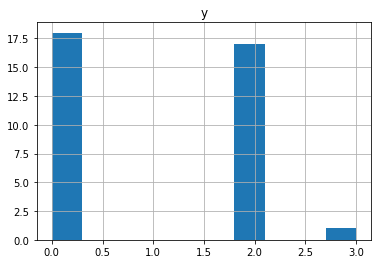

In [21]:
y_train_raw.loc[indexes_too_low_beats_train].hist()

In [22]:
#TODO change, only temporal to test a submission. For all the values where we don't have enough heartbeat, we
# simply put the values of the signal before.
X_train_beats_rpeaks_no_Nan = np.copy(X_train_beats_rpeaks)
y_train_no_Nan = np.copy(y_train_raw)
for i in indexes_too_low_beats_train:
    X_train_beats_rpeaks_no_Nan[i] = X_train_beats_rpeaks_no_Nan[i-1]
    y_train_no_Nan[i] = y_train_no_Nan[i-1]
    
X_test_beats_rpeaks_no_Nan = np.copy(X_test_beats_rpeaks)
for i in indexes_too_low_beats_test:
    X_test_beats_rpeaks_no_Nan[i] = X_test_beats_rpeaks_no_Nan[i-1]

In [23]:
# For each signal, compute its hearthrateInfos
X_train_hearthrate_infos = np.array([find_hearthrate_info(beats_rpeaks[1]) for beats_rpeaks in X_train_beats_rpeaks_no_Nan])
X_test_hearthrate_infos = np.array([find_hearthrate_info(beats_rpeaks[1]) for beats_rpeaks in X_test_beats_rpeaks_no_Nan])

/home/loic/Enter/envs/InternetAnalytics/lib/python3.9/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/loic/Enter/envs/InternetAnalytics/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/loic/Enter/envs/InternetAnalytics/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/loic/Enter/envs/InternetAnalytics/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/loic/Enter/envs/InternetAnalytics/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rco

In [24]:
X_train_noise_quantile_infos = np.array([compute_quantile_noise_in_beats(beats_rpeaks[0]) for beats_rpeaks in X_train_beats_rpeaks_no_Nan])
X_test_noise_quantile_infos = np.array([compute_quantile_noise_in_beats(beats_rpeaks[0]) for beats_rpeaks in X_test_beats_rpeaks_no_Nan])

In [25]:
X_train_QRS = np.array([find_important_values(np.mean(beats_rpeaks[0], axis=0)) for beats_rpeaks in X_train_beats_rpeaks_no_Nan])
X_test_QRS = np.array([find_important_values(np.mean(beats_rpeaks[0], axis=0)) for beats_rpeaks in X_test_beats_rpeaks_no_Nan])

In [26]:
X_train_features = np.concatenate((X_train_hearthrate_infos, X_train_noise_quantile_infos.reshape(-1,1), X_train_QRS), axis=1)
X_test_features = np.concatenate((X_test_hearthrate_infos, X_test_noise_quantile_infos.reshape(-1,1), X_test_QRS), axis=1)

In [27]:
X_train_features_scaled, X_test_features_scaled = scale(X_train_features, X_test_features)

In [28]:
#Need to correct warning above to avoid to have to impute values
imputer = KNNImputer(n_neighbors=6, weights='uniform').fit(X_train_features_scaled)

X_train_features_imputed = imputer.transform(X_train_features_scaled)
X_test_features_imputed = imputer.transform(X_test_features_scaled)

In [38]:
svc = best_svc(X_train_features_imputed, y_train_no_Nan.reshape(-1))

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END C=1.0, class_weight=balanced, kernel=rbf;, score=0.642 total time=   1.3s
[CV 2/5] END C=1.0, class_weight=balanced, kernel=rbf;, score=0.638 total time=   1.3s
[CV 3/5] END C=1.0, class_weight=balanced, kernel=rbf;, score=0.653 total time=   1.2s
[CV 4/5] END C=1.0, class_weight=balanced, kernel=rbf;, score=0.674 total time=   1.2s
[CV 5/5] END C=1.0, class_weight=balanced, kernel=rbf;, score=0.636 total time=   1.2s
[CV 1/5] END C=1.0, class_weight=None, kernel=rbf;, score=0.703 total time=   0.9s
[CV 2/5] END C=1.0, class_weight=None, kernel=rbf;, score=0.698 total time=   0.9s
[CV 3/5] END C=1.0, class_weight=None, kernel=rbf;, score=0.680 total time=   0.9s
[CV 4/5] END C=1.0, class_weight=None, kernel=rbf;, score=0.718 total time=   0.9s
[CV 5/5] END C=1.0, class_weight=None, kernel=rbf;, score=0.691 total time=   0.9s
[CV 1/5] END C=3.9810717055349722, class_weight=balanced, kernel=rbf;, score=0.671 total 

In [39]:
model = svc
sub_id = 3
prediction = pd.DataFrame(model.predict(X_test_features_imputed))

In [40]:
create_submission(sub_id, prediction)

**Solutions must be submitted on the [project website](https://aml.ise.inf.ethz.ch/task2/).**